In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [2]:
import pickle
from copy import deepcopy
from pathlib import Path

import gurobipy
from gurobipy import GRB
import dgl
import numpy as np
import torch
import matplotlib.pyplot as plt

from src.problem import get_model, get_soc, load_instance, get_feasible
from src.dataset import OnlyXInstanceEarlyFixingDataset
from src.net import InstanceGCN
from src.utils import load_from_wandb

In [5]:
9*97*2

1746

In [23]:
instances = list(Path('../data/raw').glob('97_9*.jl'))  # test instances only
# instances = sorted(instances)
instances = instances[-2:]

with open('../97_9_opts.pkl', 'rb') as f:
    opts = pickle.load(f)

net = InstanceGCN(2, readout_op=None)
net = load_from_wandb(net, 'cb3uzmsm', 'sat-gnn', 'model_last')
net.eval()

opts = [opts[i.name]['sol'].reshape((9,2*97))[:,:97].flatten() for i in instances]
ds = OnlyXInstanceEarlyFixingDataset(
    [load_instance(i) for i in instances],
    opts,
    samples_per_problem=10,
)
g1 = ds.gs[0]
g2 = ds.gs[1]

x1_opt = torch.from_numpy(opts[0])
x2_opt = torch.from_numpy(opts[1])

g1, g2

(Graph(num_nodes={'con': 5811, 'soc': 1164, 'var': 873},
       num_edges={('con', 'c2s', 'soc'): 33250, ('con', 'c2v', 'var'): 23852, ('soc', 's2c', 'con'): 33250, ('var', 'v2c', 'con'): 23852},
       metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')]),
 Graph(num_nodes={'con': 5818, 'soc': 1164, 'var': 873},
       num_edges={('con', 'c2s', 'soc'): 29811, ('con', 'c2v', 'var'): 22430, ('soc', 's2c', 'con'): 29811, ('var', 'v2c', 'con'): 22430},
       metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')]))

In [24]:
def create_batch(g, xs):
    g_batch = list()
    for x in xs:
        g_ = deepcopy(g)
        curr_feats = g_.nodes['var'].data['x']
        g_.nodes['var'].data['x'] = torch.hstack((
            # unsqueeze features dimension, if necessary
            curr_feats.view(curr_feats.shape[0],-1),
            x.view(x.shape[-1],-1),
        ))
        g_batch.append(g_)
    return dgl.batch(g_batch)

x1s = torch.randint(0, 2, (100, 873))
g1_batch = create_batch(g1, x1s)

x2s = torch.randint(0, 2, (100, 873))
g2_batch = create_batch(g2, x2s)

g1_batch, g2_batch

(Graph(num_nodes={'con': 581100, 'soc': 116400, 'var': 87300},
       num_edges={('con', 'c2s', 'soc'): 3325000, ('con', 'c2v', 'var'): 2385200, ('soc', 's2c', 'con'): 3325000, ('var', 'v2c', 'con'): 2385200},
       metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')]),
 Graph(num_nodes={'con': 581800, 'soc': 116400, 'var': 87300},
       num_edges={('con', 'c2s', 'soc'): 2981100, ('con', 'c2v', 'var'): 2243000, ('soc', 's2c', 'con'): 2981100, ('var', 'v2c', 'con'): 2243000},
       metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')]))

tensor([[0.1482, 0.5443, 0.5680,  ..., 0.2318, 0.4470, 0.5655],
        [0.1916, 0.4229, 0.6439,  ..., 0.3843, 0.2102, 0.3143],
        [0.5466, 0.3632, 0.5045,  ..., 0.2012, 0.5241, 0.4972],
        ...,
        [0.4552, 0.7895, 0.6038,  ..., 0.2182, 0.5879, 0.3593],
        [0.3349, 0.4432, 0.4339,  ..., 0.2266, 0.4360, 0.3207],
        [0.6053, 0.3503, 0.6993,  ..., 0.2286, 0.5934, 0.5008]],
       dtype=torch.float64)
[0, 0, 0, 0, 141, 873] [1, 1, 1, 1, tensor(0.6170), tensor(0.6541)]
tensor([[0.1389, 0.6815, 0.7146,  ..., 0.4664, 0.6128, 0.3869],
        [0.2626, 0.4684, 0.7111,  ..., 0.4654, 0.6156, 0.3916],
        [0.4144, 0.2005, 0.2216,  ..., 0.4671, 0.6102, 0.3141],
        ...,
        [0.1433, 0.6596, 0.5660,  ..., 0.4319, 0.3461, 0.3687],
        [0.3806, 0.6814, 0.5838,  ..., 0.4502, 0.3915, 0.3339],
        [0.6273, 0.1483, 0.7045,  ..., 0.4670, 0.6091, 0.3403]],
       dtype=torch.float64)
[0, 31, 94, 136, 193, 873] [1, tensor(0.5484), tensor(0.4787), tensor(0.6250), t

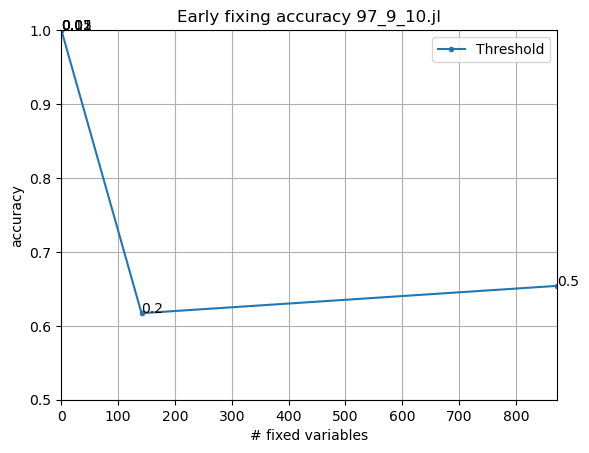

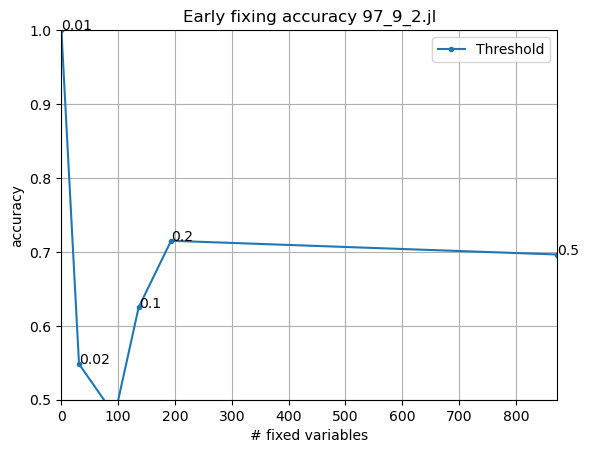

: 

In [25]:
def get_ef_accuracy(g_batch, xs, x_opt, name=None, plot=True):
    with torch.no_grad():
        y_hat = torch.sigmoid(net(g_batch))
    print(y_hat)

    y_flip = 1 - y_hat
    x_hat = (xs - y_flip).abs()  # prob. of the predicted optimal solution
    err = (x_hat - x_opt).abs()

    thresholds = [.01, .02, .05, .1, .2, .5]

    accs = list()
    ns = list()
    for thresh in thresholds:
        most_certain = (x_hat.mean(0) < thresh) | (x_hat.mean(0) >= 1 - thresh)
        if most_certain.sum() == 0:
            accs.append(1)
            ns.append(0)
            continue
        fixed_x_hat = (x_hat.mean(0)[most_certain] > .5).to(x_opt)
        fixed_x_opt = x_opt[most_certain]

        acc = (fixed_x_hat == fixed_x_opt).sum() / fixed_x_opt.shape[0]

        accs.append(acc)
        ns.append(fixed_x_hat.shape[0])

    if plot:
        fig, ax = plt.subplots()
        ax.plot(ns, accs, '.-', label='Threshold')
        ax.set_xlim((0, x_opt.shape[0]))
        ax.set_ylim((.5, 1.))
        ax.grid()
        ax.legend()

        ax.set_title('Early fixing accuracy '+str(name))
        ax.set_xlabel('# fixed variables')
        ax.set_ylabel('accuracy')

        for i, thresh in enumerate(thresholds):
            ax.annotate(thresh, (ns[i], accs[i]))

        fig.show()
    
    return thresholds, ns, accs

_, n1s, acc1s = get_ef_accuracy(g1_batch, x1s, x1_opt, name=instances[0].name)
print(n1s, acc1s)
_, n2s, acc2s = get_ef_accuracy(g2_batch, x2s, x2_opt, name=instances[1].name)
print(n2s, acc2s)

### Early Fixing Time Reduction

([0.0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5], [0], [61.51222896575928], [3064.0])

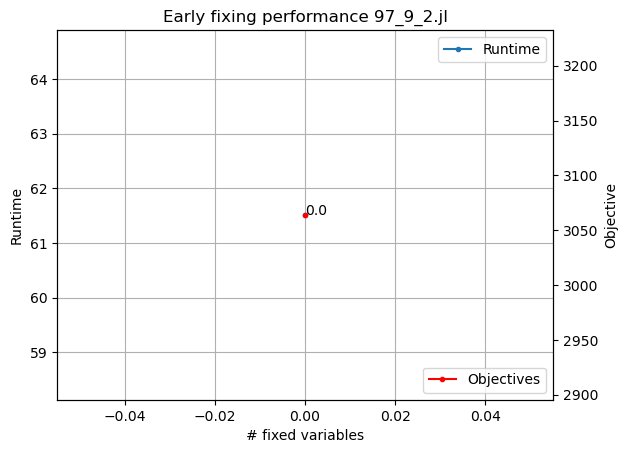

In [15]:
def get_ef_times(g_batch, xs, instance, name=None, plot=True, gap=.05):
    if isinstance(instance, str) or isinstance(instance, Path):
        instance = load_instance(instance)

    jobs = list(range(instance['jobs'][0]))
    model = get_model(jobs, instance, coupling=True, new_ineq=False)
    model.setParam('MIPGap', gap)
    model.update()

    vars_names = np.core.defchararray.array([v.getAttr(GRB.Attr.VarName) for v in model.getVars()])
    vars_names = vars_names[vars_names.find('x(') >= 0]

    # baseline results
    model_ = model.copy()
    model_.optimize()
    baseline_runtime = model_.Runtime
    baseline_obj = model_.ObjVal

    with torch.no_grad():
        y_hat = torch.sigmoid(net(g_batch))

    y_flip = 1 - y_hat
    x_hat = (xs - y_flip).abs()  # prob. of the predicted optimal solution

    thresholds = [0., .01, .02, .05, .1, .2, .5]
    # thresholds = [0., .01, .02, .05, .1]

    runtimes = list()
    objs = list()
    ns = list()
    for thresh in thresholds:
        most_certain = (x_hat.mean(0) < thresh) | (x_hat.mean(0) > 1 - thresh)

        if most_certain.sum() == 0:
            runtimes.append(baseline_runtime)
            objs.append(baseline_obj)
            ns.append(0)
            continue

        fixed_x_hat = (x_hat.mean(0)[most_certain] > .5).to(x_hat)

        fixed_vars_names = vars_names[most_certain]

        # fix variables
        model_ = model.copy()
        for fixed_var_name, fixed_var_X in zip(fixed_vars_names, fixed_x_hat):
            model_.getVarByName(fixed_var_name).lb = fixed_var_X
            model_.getVarByName(fixed_var_name).ub = fixed_var_X

        model_.update()
        model_.optimize()

        if model_.status == 3:
            continue

        runtimes.append(model_.Runtime)
        objs.append(model_.ObjVal)
        ns.append(fixed_x_hat.shape[0])

    if plot:
        fig, ax = plt.subplots()
        ax.plot(ns, runtimes, '.-', label='Runtime')
        # ax.set_xlim((0, x_opt.shape[0]))
        ax.grid()
        ax.legend(loc=1)

        ax.set_title('Early fixing performance '+str(name))
        ax.set_xlabel('# fixed variables')
        ax.set_ylabel('Runtime')

        obj_ax = ax.twinx()
        obj_ax.plot(ns, objs, '.-', c='r', label='Objectives')
        obj_ax.legend(loc=4)
        obj_ax.set_ylabel('Objective')

        for i, n in enumerate(ns):
            ax.annotate(thresholds[i], (n, runtimes[i]))

        fig.show()

    return thresholds, ns, runtimes, objs

# get_ef_times(g1_batch, x1s, instances[0], name=instances[0].name)
get_ef_times(g2_batch, x2s, instances[1], name=instances[1].name)

([0.0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5], [0], [62.91289401054382], [3064.0])

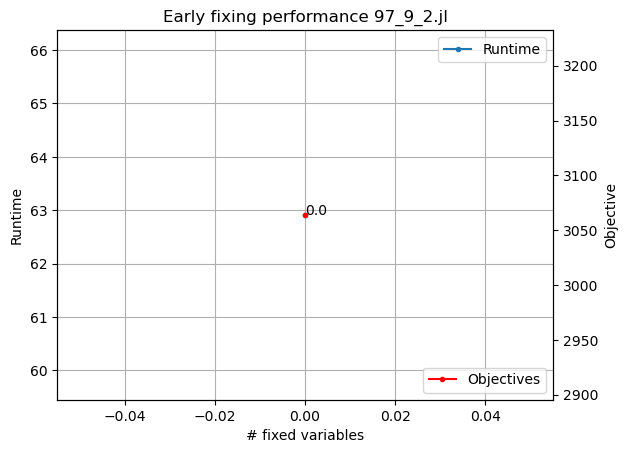

In [14]:
get_ef_times(g2_batch, x2s, instances[1], name=instances[1].name)

In [39]:
g_batch = g1_batch
xs = x1s

instance = load_instance(instances[0])
jobs = list(range(instance['jobs'][0]))
model = get_model(jobs, instance, coupling=True, new_ineq=False)
model.setParam('MIPGap', .05)
model.update()

vars_names = np.core.defchararray.array([v.getAttr(GRB.Attr.VarName) for v in model.getVars()])
vars_names = vars_names[(vars_names.find('x(') >= 0) | (vars_names.find('phi(') >= 0)]

with torch.no_grad():
    y_hat = torch.sigmoid(net(g_batch))

y_flip = 1 - y_hat
x_hat = (xs - y_flip).abs()  # prob. of the predicted optimal solution

thresholds = [0., .01, .02, .05, .1, .2, .5]
# thresholds = [0., .01, .02, .05, .1]

runtimes = list()
objs = list()
ns = list()
thresh = .02

most_certain = (x_hat.mean(0) < thresh) | (x_hat.mean(0) > 1 - thresh)

fixed_x_hat = (x_hat.mean(0)[most_certain] > .5).to(x_hat)

fixed_x_hat

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)

In [42]:
for var_name in vars_names:
    var = var_name.split('(')[0]
    j, t = var_name.split('(')[1][:-1].split(',')
    j = int(j)
    t = int(t)

    if var
    break

0,0


In [48]:
vars_names.reshape((9,194)).shape

(9, 194)

In [49]:
len(vars_names) == 9 * 194

True

In [57]:
from src.problem import get_feasible

x_candidate = x_hat.mean(0).numpy().reshape((9, 194))
x_feasible = get_feasible(model, x_candidate, instance)

x_feasible

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [70]:
from src.problem import get_feasible

x_feasible = get_feasible(model, x_hat.mean(0).numpy().reshape((9, 194)), instance, weighted=True)
x_cand = (x_hat.mean(0) > .5).to(x_hat)
x_cand_feas = x_feasible.flatten()

In [71]:
x_cand.shape

torch.Size([1746])

In [72]:
x_cand_feas.shape

(1746,)

In [75]:
feas_mask = x_cand.numpy() == x_cand_feas
feas_mask

array([ True,  True,  True, ...,  True,  True,  True])

In [79]:
most_certain.numpy() * feas_mask

array([False, False, False, ...,  True, False, False])

([0.0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5],
 [0, 0, 47],
 [2.3700289726257324, 2.3700289726257324, 2.8245890140533447],
 [2785.0, 2785.0, 2786.0])

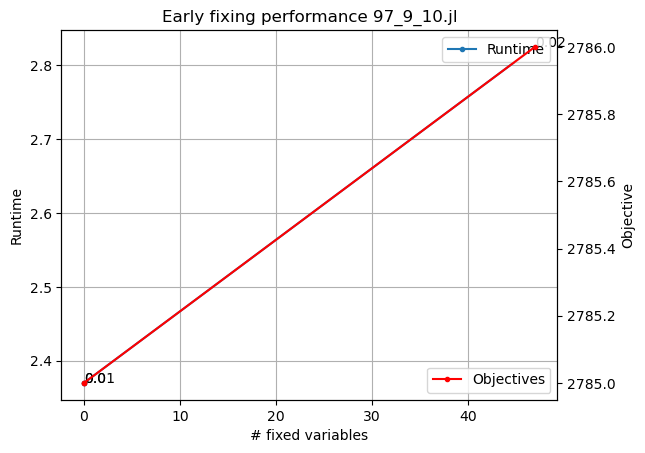

In [6]:
def get_ef_feas_times(g_batch, xs, instance, name=None, plot=True, gap=.05):
    if isinstance(instance, str) or isinstance(instance, Path):
        instance = load_instance(instance)

    jobs = list(range(instance['jobs'][0]))
    model = get_model(jobs, instance, coupling=True, new_ineq=False)
    model.setParam('MIPGap', gap)
    model.update()

    vars_names = np.core.defchararray.array([v.getAttr(GRB.Attr.VarName) for v in model.getVars()])
    vars_names = vars_names[(vars_names.find('x(') >= 0) | (vars_names.find('phi(') >= 0)]

    # baseline results
    model_ = model.copy()
    model_.optimize()
    baseline_runtime = model_.Runtime
    baseline_obj = model_.ObjVal

    with torch.no_grad():
        y_hat = torch.sigmoid(net(g_batch)).numpy()

    y_flip = 1 - y_hat
    x_hat = (xs - y_flip).abs().mean(0).numpy()  # prob. of the predicted optimal solution

    # feasibility recovery
    x_feasible = get_feasible(model, x_hat.reshape((9, 194)), instance, weighted=True)
    x_cand = (x_hat > .5).astype(int)
    x_cand_feas = x_feasible.flatten()
    feas_mask = x_cand == x_cand_feas

    thresholds = [0., .01, .02, .05, .1, .2, .5]
    # thresholds = [0., .01, .02, .05, .1]

    runtimes = list()
    objs = list()
    ns = list()
    for thresh in thresholds:
        most_certain = (x_hat < thresh) | (x_hat > 1 - thresh)
        most_certain *= feas_mask  # only most certain that were not changed for feasibility

        if most_certain.sum() == 0:
            runtimes.append(baseline_runtime)
            objs.append(baseline_obj)
            ns.append(0)
            continue

        fixed_x_hat = (x_hat[most_certain] > .5).astype(int)

        fixed_vars_names = vars_names[most_certain]

        # fix variables
        model_ = model.copy()
        for fixed_var_name, fixed_var_X in zip(fixed_vars_names, fixed_x_hat):
            model_.getVarByName(fixed_var_name).lb = fixed_var_X
            model_.getVarByName(fixed_var_name).ub = fixed_var_X

        model_.update()
        model_.optimize()

        if model_.status == 3:
            break

        runtimes.append(model_.Runtime)
        objs.append(model_.ObjVal)
        ns.append(fixed_x_hat.shape[0])

    if plot:
        fig, ax = plt.subplots()
        ax.plot(ns, runtimes, '.-', label='Runtime')
        # ax.set_xlim((0, x_opt.shape[0]))
        ax.grid()
        ax.legend(loc=1)

        ax.set_title('Early fixing performance '+str(name))
        ax.set_xlabel('# fixed variables')
        ax.set_ylabel('Runtime')

        obj_ax = ax.twinx()
        obj_ax.plot(ns, objs, '.-', c='r', label='Objectives')
        obj_ax.legend(loc=4)
        obj_ax.set_ylabel('Objective')

        for i, n in enumerate(ns):
            ax.annotate(thresholds[i], (n, runtimes[i]))

        fig.show()

    return thresholds, ns, runtimes, objs

get_ef_feas_times(g1_batch, x1s, instances[0], name=instances[0].name)

([0.0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5],
 [0, 0, 35],
 [50.43629693984985, 50.43629693984985, 47.224790811538696],
 [3064.0, 3064.0, 3064.0])

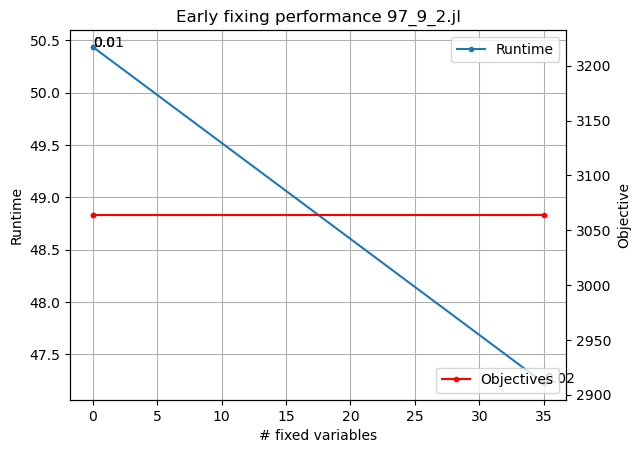

In [7]:
get_ef_feas_times(g2_batch, x2s, instances[1], name=instances[1].name)